# Denoise Yield Monitor Data

Yield monitor data is an excellent field diagnostic layer of information that provides insights about the high and low yield producing areas of the field. Yield maps can reveal spots that have low fertility values, high/low pH values, excessive water standing, soils with low water holding capacity that are vulnerable to dry periods, areas of the field affected by soil compaction due to traffic, or a combination of all the above.

The harvesting process is not simple and introduces spurious observations. This is affected by driving patterns, grain mositure, presence of weeds, field traffic condicitons, field shape, and field elevation changes are among the most common. Combine drivers have to maximize the time the combine is ingesting grain using the entire width of the platform, but during turns or at the beginning/end of the harvesting process this may not be achievable and thus it looks like the yield is lower in that part of the field. This is just an artifice and points out the need to clean yield monitor data before drawing any conclusions.

The yield monitor of modern combines collects data about combined speed, grographic position, time, grain flow, and grain moisture in real time at a temporal resolution of 1 second. This exorbitant temporal resolution generates rich datasets for spatial variability analysis.

## Dataset description

In this exercise we will use a real yield monitor dataset from a soybean crop harvested in the state of Kansas in October of 2015. The farm and geogrpahic infromation were removed to preserve the farmers anonimity. So, the geographic coordinates were replaced by relative UTM coordinates. The X and Y coordinates are in meters relative to the center of the field (X=0, Y=0).


Units of variables in dataset:

- Flow in lbs/second
- Area in acres
- Distance in inches
- Duration in seconds
- Yield in lbs/acre
- Moisture in percent
- Width in inches


## File formats

Yield monitor data is often saved using the Shapefile format (`.shp`). In this case I saved the file in `.csv` format to enable everyone to access the exercise using the `pandas` library.

For those interested in applying the same techniques to their own yield monitor data in `.shp` format, I recomend installing the `geopandas` library. The line sbelow should get you started.

```
!pip install geopandas # Run in separate cell
df = gpd.read_file("../datasets/yield_monitor.shp")
df.head(
```


In [35]:
#import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [36]:
df = pd.read_csv("../datasets/yield_monitor.csv")
print(df.shape)
df.head()


(3281, 12)


,Geometry,X,Y,Crop,TimeStamp,Yield,Flow,Moisture,Duration,Distance,Width,Area
0,Point,-156.576874,-69.681188,Soybeans,2015-10-10 15:07:35,50.51,5.6990,13.0,1.0,25.1969,468.1102,0.001880
1,Point,-156.100303,-70.083748,Soybeans,2015-10-10 15:07:36,51.41,5.8003,13.0,1.0,25.1969,468.1102,0.001880
2,Point,-155.632047,-70.508652,Soybeans,2015-10-10 15:07:37,50.66,5.7151,13.0,1.0,25.1969,468.1102,0.001880
3,Point,-155.198382,-70.945248,Soybeans,2015-10-10 15:07:38,54.20,5.8286,13.0,1.0,24.0157,468.1102,0.001792
4,Point,-154.808573,-71.360394,Soybeans,2015-10-10 15:07:39,55.86,5.5141,13.0,1.0,22.0472,468.1102,0.001645


In [37]:
# Convert dates to Pandas datetime format
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%Y/%m/%d %H:%M:%S")


In [38]:
# Compute speed in miles per hour (mph)
df["Speed"] = df["Distance"] / df["Duration"] # in inches/second
df["Speed"] = df["Speed"]/63360*3600 # convert to miles/hour


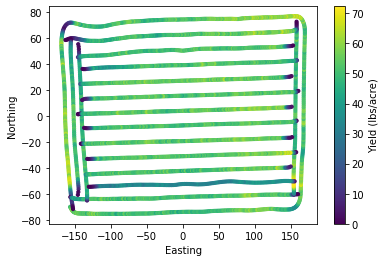

In [39]:
# Examine data
plt.scatter(df["X"], df["Y"], s=10, c=df["Yield"])
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.colorbar(label="Yield (lbs/acre)")
plt.show()


An extrmely useful habit is to plot the data. Histograms are great at describing the central tendency and dispersion of a given variable in a single figure. Based on histograms we can select and fine-tune the variables and thresholds that we will use to denoise our yield monitor data.


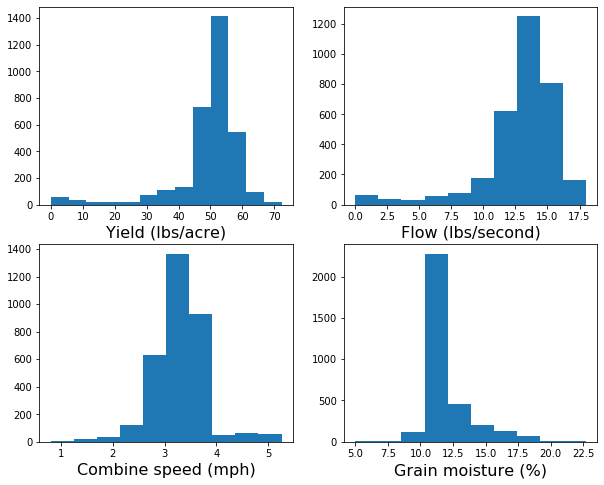

In [40]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.hist(df["Yield"], bins=13)
plt.xlabel("Yield (lbs/acre)", size=16)

plt.subplot(2,2,2)
plt.hist(df["Flow"])
plt.xlabel("Flow (lbs/second)", size=16)

plt.subplot(2,2,3)
plt.hist(df["Speed"])
plt.xlabel("Combine speed (mph)", size=16)

plt.subplot(2,2,4)
plt.hist(df["Moisture"])
plt.xlabel("Grain moisture (%)", size=16)

plt.show()

In [41]:
# Create copy of original DataFrame
df_clean = df


## Filtering rules with clear physical meaning

In [42]:
idx_too_slow = df["Speed"] < 2.5
idx_too_fast = df["Speed"] > 4
idx_too_wet = df["Moisture"] > 20
idx_too_dry = df["Moisture"] < 10
idx_low_flow = df["Flow"] <= 10
idx_high_flow = df["Flow"] >= 18
idx = idx_too_slow | idx_too_fast | idx_too_dry | idx_too_wet | idx_low_flow | idx_high_flow
df_clean = df[~idx]


Up to here, the method will probably clean most maps from yield monitors. If you want to stop here I also suggest adding the following two boolean conditions to filter out outliers. If you decide to implement a more sophisticaded approach, then you can probably omit the next two lines since we will be implementing a moving filter that will capture outliers later on.

```python
idx_high_yield = df["Yield"] >= df["Yield"].quantile(0.95)
idx_low_yield = df["Yield"] <= df["Yield"].quantile(0.05)
```


In [43]:
print(df.shape)
print(df_clean.shape)
removed_points = df.shape[0] - df_clean.shape[0]
print("Removed",str(removed_points),'points')


(3281, 13)
(2760, 13)
Removed 521 points


Let's generate a plot showing the original and resulting dataset after our first layer of cleaning. We will circle the points that we removed to check our work.

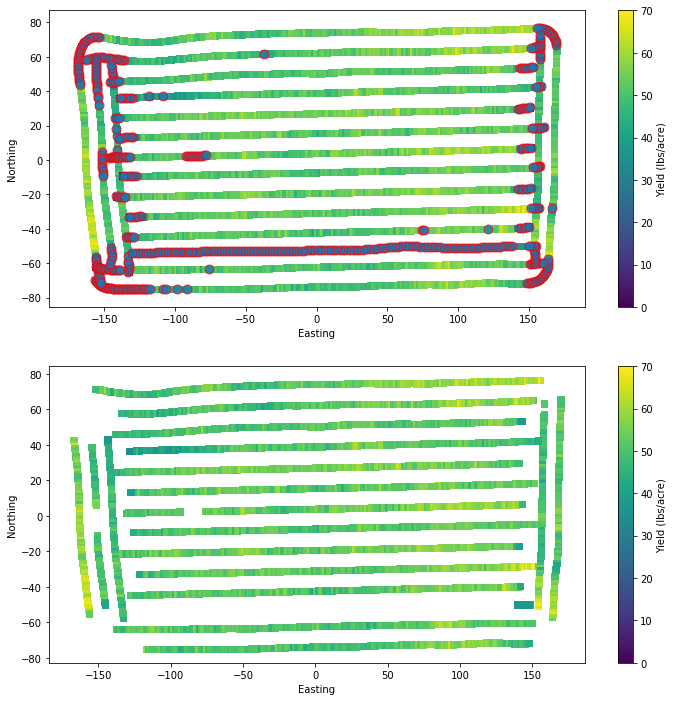

In [44]:
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
plt.scatter(df["X"], df["Y"], s=40, marker='s', c=df["Yield"])
plt.colorbar(label="Yield (lbs/acre)")
plt.clim(0,70)
plt.scatter(df.loc[idx,"X"], df.loc[idx,"Y"], 
            s=80,
            marker='o', 
            facecolor=None, 
            edgecolor='r', 
            alpha=0.8)
plt.xlabel('Easting')
plt.ylabel('Northing')

plt.subplot(2,1,2)
plt.scatter(df_clean["X"], df_clean["Y"], s=40,  marker='s', c=df_clean["Yield"])
plt.colorbar(label="Yield (lbs/acre)")
plt.clim(0,70)
plt.xlabel('Easting')
plt.ylabel('Northing')

plt.show()


In [45]:
# Remove NaNs
df_clean = df_clean.dropna()


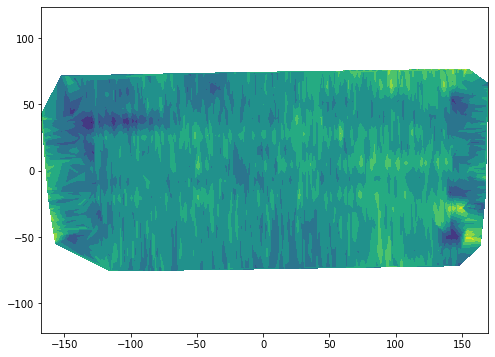

In [52]:
plt.figure(figsize=(8,6))
plt.tricontourf(df_clean["X"], df_clean["Y"], df_clean["Yield"], levels=7)
plt.axis('equal')
plt.show()


In [53]:
# Reset index
df_clean.reset_index(drop=True, inplace=True)
df_clean.head()


,Geometry,X,Y,Crop,TimeStamp,Yield,Flow,Moisture,Duration,Distance,Width,Area,Speed
0,Point,-116.700755,-75.081549,Soybeans,2015-10-10 15:08:21,59.83,12.1293,10.2,1.0,45.2756,468.1102,0.003379,2.572477
1,Point,-115.518013,-75.072397,Soybeans,2015-10-10 15:08:22,49.25,10.1585,10.4,1.0,46.0630,468.1102,0.003438,2.617216
2,Point,-114.387442,-75.064138,Soybeans,2015-10-10 15:08:23,56.08,11.0729,10.9,1.0,44.0945,468.1102,0.003291,2.505369
3,Point,-113.230785,-75.055433,Soybeans,2015-10-10 15:08:24,51.03,10.2547,11.2,1.0,44.8819,468.1102,0.003349,2.550108
4,Point,-112.073939,-75.057824,Soybeans,2015-10-10 15:08:25,51.44,10.4287,11.5,1.0,45.2756,468.1102,0.003379,2.572477


## Moving filters

A moving filter is usually a sliding window that performs a smoothing operation. This usually works great with regular grids, but in the case of yield monitor data we deal with irregular grids, which requires that we handle the window in a slighly different way. 

We will iterate over each point collected by the combine and at each iteration step we will find the observations within a given distance from the combine and we will either:
    
- Assign the current point the median value of all its neighboring points within a specific distance radius.
    
- Use the yield value of all the selected neighboring points to determine whether the value of the current point is within the 5 and 95th percentile of the local yields.
    
Certainly there are many other options. I just came up with these two simple approaches based on previous studies and my own experience.

In any case, we need to be able to compute the distance from the current point in the iteration to all the other points. This is how we will determine the neighbors.


### Function to compute Euclidean distance

In [54]:
def edist(xpoint,ypoint,xvec,yvec):
    """Compute and sort Euclidean distance from a point to all other points."""
    distance = np.sqrt((xpoint - xvec)**2 + (ypoint - yvec)**2)
    idx = np.argsort(distance)
    
    return {"distance":distance, "idx":idx}


### Moving median filter

In [56]:
df_medfilter = df_clean

for i in range(df_medfilter.shape[0]):
    
    # Compute Euclidean distance from each point to the rest of the points
    D = edist(df_medfilter["X"][i], df_medfilter["Y"][i], df_medfilter["X"], df_medfilter["Y"])

    
    # Find index of neighbors
    idx = D["distance"] <= 5 # meters
    
    # Replace current value with median of neighbors
    df_medfilter.loc[i,"Yield"] = df_medfilter.loc[idx,"Yield"].median()

# This can take a while, so let's print something to know that the interpreter is done.
print('Done!')


Done!


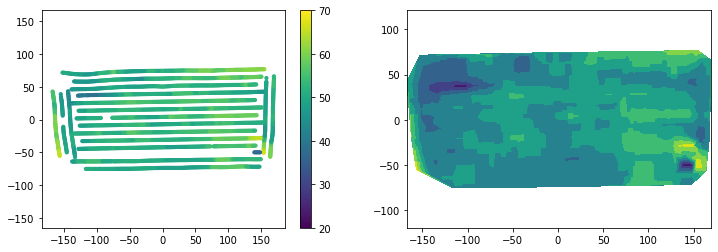

In [57]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(df_medfilter["X"], df_medfilter["Y"], s=10, c=df_medfilter["Yield"])
plt.colorbar()
plt.clim(20, 70)
plt.axis('equal')

plt.subplot(1,2,2)
plt.tricontourf(df_medfilter["X"], df_medfilter["Y"], df_medfilter["Yield"])
plt.axis('equal')

plt.show()


### Moving filter to detect outliers

In [74]:
df_outfilter = df_clean.copy()

for i in range(df_outfilter.shape[0]):
    
    # Compute Euclidean distance from each point to the rest of the points
    D = edist(df_outfilter["X"][i], df_outfilter["Y"][i], df_outfilter["X"], df_outfilter["Y"])
    
    idx = D["distance"] <= 5 # meters
    current_point_yield =  df_outfilter.loc[i,"Yield"]
    
    # Find lower and upper threshold based on percentiles
    Q5 = df_outfilter.loc[idx,"Yield"].quantile(0.05)
    Q95 = df_outfilter.loc[idx,"Yield"].quantile(0.95)
    
    # If current point is lower or greater than plausible neighbor values, then set to NaN
    if (current_point_yield < Q5) | (current_point_yield > Q95):
        df_outfilter.loc[i,"Yield"] = np.nan

print("Done!")

Done!


Check if your method detected any outliers, which should have been assigned `NaN` to the yield variable.

In [79]:
df_outfilter["Yield"].isna().sum()


392

There are some `NaN` values. The interpolation method `tricontourf` does not handle `NaN`, so we need to remove them from the DataFrame first. We will use the Pandas `dropna()` to do this easily.


In [80]:
df_outfilter = df_outfilter.dropna()
df_outfilter["Yield"].isna().sum()


0

Perfect, our DataFrame no longer contains `NaN` values. Before we proceed, let's also check the difference in the number of points between the two methods. Just to know whether our filtering was a bit execessive. If it was, then realexed some of the initial paramters or the quantiles threshlds.


In [81]:
print(df_medfilter.shape)
print(df_outfilter.shape)


(2760, 13)
(2368, 13)


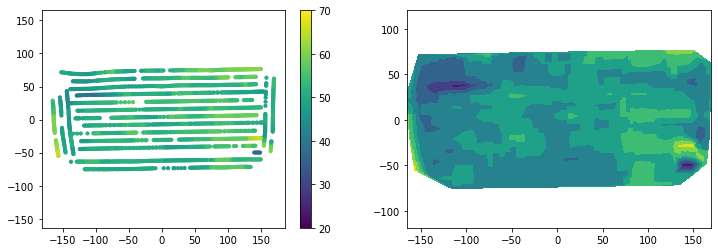

In [83]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(df_outfilter["X"], df_outfilter["Y"], s=10, c=df_outfilter["Yield"])
plt.colorbar()
plt.clim(20, 70)
plt.axis('equal')

plt.subplot(1,2,2)
plt.tricontourf(df_outfilter["X"], df_outfilter["Y"], df_outfilter["Yield"])
plt.axis('equal')

plt.show()


## Observations

The approaches tested in exercise yieldded somewhat similar results. The first layer of outliers removal based on the plausible value of variables with clear physical meaning such as combine spped, grain flow rate, and grain moisture content are an effective way of removing clear outliers.

The first layer does note result in a clear interpolation, at least using the `tricontourf` function. I'm sure that some of the filters with scipy and image processing toolboxes can solve this issue without further processing.

A median filter is a powerful filter widely used in image analysis and was effective to remove outliers and dramatically improved the map in terms of smoothness and visual patterns. This method does not preserve the original values.

The moving window to remove outliers based on quantile thresholds performed similar to the median filter and represents an alternative method. This method preserves the original values and removes values that are considered outliers.

The method of choice depends on the user, the complexity of the data, and the performance of the methods compared to known field patterns and observations during harvest.


## References

Khosla, R. and Flynn, B., 2008. Understanding and cleaning yield monitor data. Soil Science Step-by-Step Field Analysis, (soilsciencestep), pp.113-130.

Kleinjan, J., Chang, J., Wilson, J., Humburg, D., Carlson, G., Clay, D. and Long, D., 2002. Cleaning yield data. SDSU Publication.